<a href="https://colab.research.google.com/github/yalyakoob/Financial-Risk-Modeling-for-P2P-Lending/blob/main/Financial_Risk_Modeling_for_P2P_Lending_Applications.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Financial Risk Modeling for P2P Lending Applications

###Introduction

###Project Scope/Business Challenge

Building a predictive model using different machine learning techniques to accurately predict if a potential borrower will default on their loan.


## Importing Libraries

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
    !pip install yellowbrick
    !pip install pdpbox
    !pip install shap

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from pandas_profiling import ProfileReport
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.under_sampling import  EditedNearestNeighbours, TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import category_encoders as ce
from sklearn.metrics import plot_roc_curve, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier

pd.options.display.max_rows = 100

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


##Exploratory Data Analysis/ Data Wrangling

In [3]:
df = pd.read_csv('loan.csv', low_memory= False)

In [ ]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,...,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0,Jan-85,1,NaN,NaN,3,0,13648,83.70%,9,f,0.00,0.00,5863.155187,5833.84,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0,Apr-99,5,NaN,NaN,3,0,1687,9.40%,4,f,0.00,0.00,1008.710000,1008.71,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,real estate business,606xx,IL,8.72,0,Nov-01,2,NaN,NaN,2,0,2956,98.50%,10,f,0.00,0.00,3005.666844,3005.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0,Feb-96,1,35.0,NaN,10,0,5598,21%,37,f,0.00,0.00,12231.890000,12231.89,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-11,Current,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0,Jan-96,0,38.0,NaN,15,0,27783,53.90%,38,f,524.06,524.06,3513.330000,3513.33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [ ]:
df.shape

(39717, 111)

In [ ]:
#There are too many features. I will do some exploratory data analysis to figure out which features are important and which ones we can drop. 

In [ ]:
df.info(100) # Information for data types of first 100 features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 111 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   id                              int64  
 1   member_id                       int64  
 2   loan_amnt                       int64  
 3   funded_amnt                     int64  
 4   funded_amnt_inv                 float64
 5   term                            object 
 6   int_rate                        object 
 7   installment                     float64
 8   grade                           object 
 9   sub_grade                       object 
 10  emp_title                       object 
 11  emp_length                      object 
 12  home_ownership                  object 
 13  annual_inc                      float64
 14  verification_status             object 
 15  issue_d                         object 
 16  loan_status                     object 
 17  pymnt_plan                    

In [ ]:
df.isnull().sum() # We can see there are features that have a lot of missing data. 

id                                0
member_id                         0
loan_amnt                         0
funded_amnt                       0
funded_amnt_inv                   0
                              ...  
tax_liens                        39
tot_hi_cred_lim               39717
total_bal_ex_mort             39717
total_bc_limit                39717
total_il_high_credit_limit    39717
Length: 111, dtype: int64

In [ ]:
df.head(100).T.duplicated() # We have numerous duplicated columns that should be removed

id                            False
member_id                     False
loan_amnt                     False
funded_amnt                   False
funded_amnt_inv               False
                              ...  
tax_liens                      True
tot_hi_cred_lim                True
total_bal_ex_mort              True
total_bc_limit                 True
total_il_high_credit_limit     True
Length: 111, dtype: bool

In [4]:
  def wrangle(df1):
    #removing features with > 50 % of observations missing
    observation_threshold = len(df)/2
    df1 = df1.dropna(thresh = observation_threshold, axis = 1)
    #removing redundant/unnecessary features
    df1.drop(columns='desc', inplace=True) # removing unecessary text information for each loan
    df1.drop(columns = 'url', inplace = True) #url for each loan 
    df1.drop(columns = 'id', inplace = True) #identifier variable that can be dropped as we don't get much information from it
    df1.drop(columns = 'member_id', inplace = True) #another identifier variable that can be dropped as we don't get much information from it
    df1.drop(columns = 'grade', inplace = True) #redundant feature as grade is based on interest rate
    df1.drop(columns = 'sub_grade', inplace = True) #redundant feature based on grade
    df1.drop(columns = 'zip_code', inplace = True) # redundancies with addr_state feature as only 3 of the 5 digits are not hashed so we cannot pinpoint location of borrower/also has high cardinality
    df1.drop(columns = 'pub_rec_bankruptcies', inplace = True) # 95 % of observations are zeros for this feature
    df1.drop(columns = 'title', inplace = True) # Title columns overlaps with purpose column and has high cardinality
    df1.drop(columns = 'addr_state', inplace = True) # will drop because it would be hard to understand the effect of the borrower's state on a loan
    #columns with only one unique value. These features would not aid in the class seperability we are striving for.
    cols_to_drop = ['collections_12_mths_ex_med', 'tax_liens', 'policy_code', 'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens', 'pymnt_plan', 'initial_list_status', 'application_type']
    df1.drop(columns = cols_to_drop, inplace = True)
    
    #removing high cardinality features
    df1.drop(columns = 'emp_title', inplace = True) # high cardinality categorical variable
    df1.drop(columns = 'last_credit_pull_d', inplace = True) # high cardinality date object
    df1.drop(columns = 'earliest_cr_line', inplace = True) #high cardinality date object

    #removing features that can potentially cause target leakage in which the model is built with information that will not be available for the unseen data
    df1.drop(columns = 'issue_d', inplace = True)
    df1.drop(columns =  'funded_amnt_inv', inplace = True)
    df1.drop(columns = 'funded_amnt', inplace = True)
    df1.drop(columns = 'out_prncp', inplace = True)
    df1.drop(columns = 'out_prncp_inv', inplace = True)
    df1.drop(columns = 'total_pymnt', inplace = True)
    df1.drop(columns = 'total_pymnt_inv', inplace = True)
    df1.drop(columns = 'total_rec_prncp', inplace = True)
    df1.drop(columns = 'total_rec_int', inplace = True)
    df1.drop(columns = 'total_rec_late_fee', inplace = True)
    df1.drop(columns = 'recoveries', inplace = True)
    df1.drop(columns = 'collection_recovery_fee', inplace = True)
    df1.drop(columns = 'last_pymnt_d', inplace = True)
    df1.drop(columns = 'last_pymnt_amnt', inplace = True)

    #remove observations with current target class
    class_to_drop = df1[df1['loan_status'] == 'Current'].index
    df1.drop(class_to_drop, inplace = True)

    #remove null observations for potentially important features
    df1.dropna(subset = ['emp_length'], inplace = True)
    #df1.dropna(subset = ['title'], inplace = True)
    df1.dropna(subset = ['revol_util'], inplace = True)

    #mixed data types conversion
    for col in ['int_rate', 'revol_util']:
      df1[col] = df1[col].str.rstrip('%').astype('float') #removing percent sign and converting to floats.


  
    return df1

In [5]:
df = wrangle(df)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A va

In [ ]:
 #After removing features with more than 50 % null values and some unecessary columns I was able to reduce to 52 features

In [ ]:
df.describe() #summary statistics for numerical features

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc
count,37497.000000,37497.000000,37497.000000,3.749700e+04,37497.000000,37497.000000,37497.000000,37497.000000,37497.000000,37497.000000,37497.000000,37497.000000
mean,11127.362856,11.958772,324.858107,6.943653e+04,13.288131,0.147078,0.872390,9.304264,0.053738,13379.139958,48.861742,22.098035
std,7353.972102,3.682062,208.906836,6.467208e+04,6.659208,0.493230,1.071211,4.394866,0.234659,15896.953395,28.341493,11.413448
min,500.000000,5.420000,15.690000,4.000000e+03,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000
25%,5500.000000,8.940000,167.530000,4.100000e+04,8.160000,0.000000,0.000000,6.000000,0.000000,3711.000000,25.400000,13.000000
50%,10000.000000,11.830000,280.260000,6.000000e+04,13.390000,0.000000,1.000000,9.000000,0.000000,8856.000000,49.300000,20.000000
75%,15000.000000,14.420000,429.350000,8.300000e+04,18.550000,0.000000,1.000000,12.000000,0.000000,17017.000000,72.400000,29.000000
max,35000.000000,24.400000,1305.190000,6.000000e+06,29.990000,11.000000,8.000000,44.000000,4.000000,149588.000000,99.900000,90.000000


In [ ]:
df.describe(include = 'O') #Summary statistics for object data type features

,term,emp_length,home_ownership,verification_status,loan_status,purpose
count,37497,37497,37497,37497,37497,37497
unique,2,11,5,3,2,14
top,36 months,10+ years,RENT,Not Verified,Fully Paid,debt_consolidation
freq,28243,8487,18047,16250,32113,17664


##Data Leakage

Data leakage can come in two forms, either target leakage or train-test contamination. Since this dataset is for historical data, some features can  cause target leakage in which the model is built with information that will not be available for the unseen data and when the model is used for future loans. This can cause overfitting and result in low generalizability for our model. I have identified a few features that can cause potential target leakage so I will be dropping those features. I will focus on features that would not be available for future loans since future loans have not been funded yet. More specifically, features that assume a loan has already been funded need to be omitted as future loans are not funded yet.   
Potential Target Leakage Features:


* **issue_d**: The dates of previously funded loans
* **funded_amnt & funded_amnt_inv**: Both can cause target leakage as future loans have not been funded yet 
* **out_prncp, out_prncp_inv, & total_rec_prncp**: describe remaining outstanding principal/principal received for a loan, these features assume that the loan has already been funded and can cause target leakage since future loans are not funded yet. 
* **total_pymt & total_pymt_inv**: features describing payments received up to data for a loan. Also, assume that a loan has been funded and can cause target leakage.
* **total_rec_int**: descibes interest received.
* **total_rec_late_fee**: describes late fees received.
* **recoveries & collection_recovery_fee**: describe post charge off fees
* **last_pymnt_d & last_pymnt_amnt**: describe last month payment received and last month payment amount 












In [ ]:
df.shape #after removing more redundant/ high cardinality/ potential target leakage features we were able to further reduce our 52 feautures to 32 features

(37497, 18)

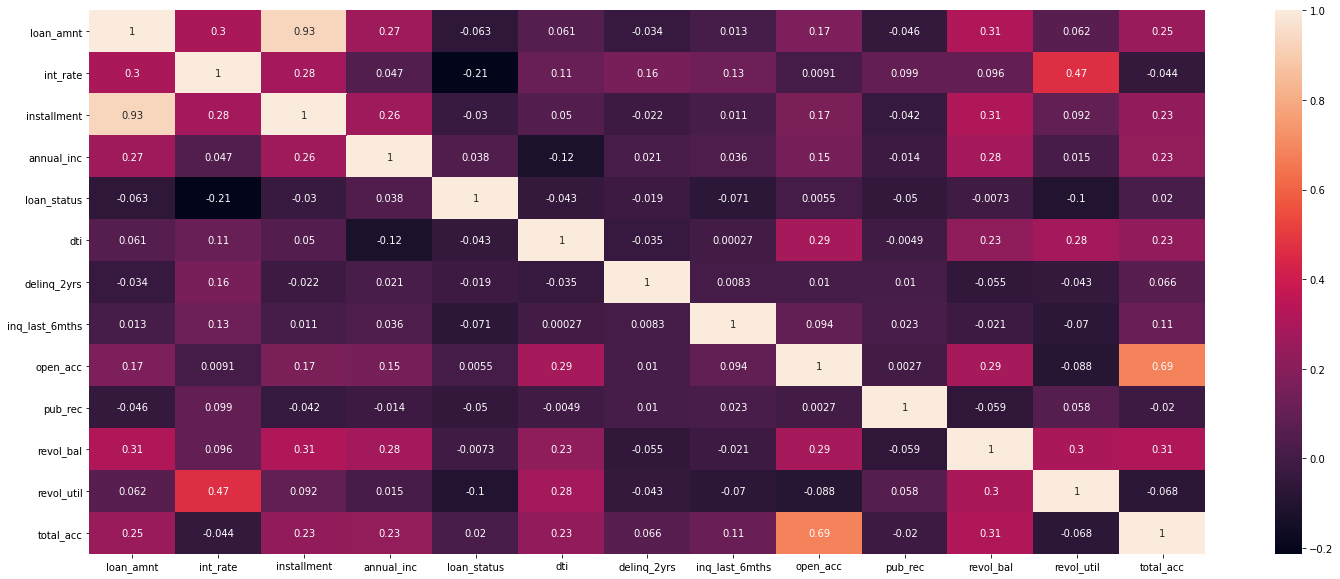

In [ ]:
plt.figure(figsize = (25,10))
sns.heatmap(df.corr(), annot = True) #Checking for unnaturally highly correlated features with our target to further prevent target leakage

## Target Variable

After cleaning our dataset and reducing our features to a reasonable number I can define the target variable my model will potentially predict. 
I will be using the loan_status feature as my target variable as it describes if a loan defaulted or was fuilly paid.  


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


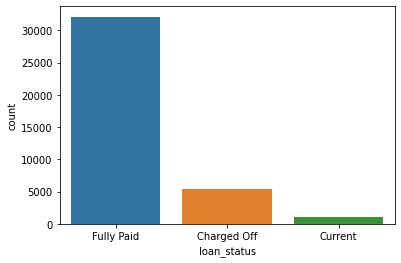

In [ ]:
sns.countplot(df.loan_status) #This is the distribution of the target variable

In [ ]:
df.loan_status.value_counts(normalize= True)

Fully Paid     0.832051
Charged Off    0.139500
Current        0.028449
Name: loan_status, dtype: float64

We can see that the class distribution in the target variable is imbalanced with the majority class dominating over 83 % of the data points and the charged off/defaulted loans only accounting for roughly 14 % of the data points. Also, there is another minority class accounting for about 3 % of the data points. I will be removing observations with this class as loans with a status current assume a non- default loan and can create more imbalance in the class distribution. We will treat this problem as a binary classification problem where loans are either fully paid or charged off/defaulted. 

######Transforming Target Variable 

After removing the 'current' minority class from the target variable. I am now able to address the target variable as a binary variable. I will using a user defined functio to transform the target variable into numerical form. The Fully Paid(positive cases) will be represented with 1's and the Charged Off(negative cases) will be represented with 0's.

In [9]:
def target_transformer(val):
  if val == 'Fully Paid':
    return 1
  else:
    return 0

In [10]:
df['loan_status'] = df['loan_status'].apply(target_transformer) #Applying our user defined function to the target feature

##Feature Engineering

######Missing Values

In [ ]:
#Even though employee length is missing alot of values it can be potentially useful in predicting risky/non risky borrowers

In [ ]:
df.pub_rec_bankruptcies.unique()  #Initially had 697 missing values


array([ 0.,  1.,  2., nan])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


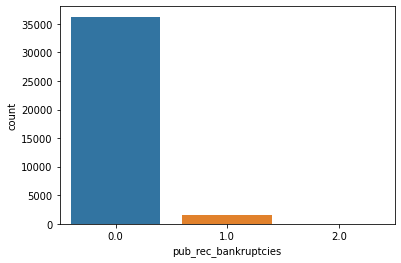

In [ ]:
sns.countplot(df.pub_rec_bankruptcies)

In [ ]:
df.pub_rec_bankruptcies.value_counts(normalize = True)

0.0    0.956653
1.0    0.043215
2.0    0.000132
Name: pub_rec_bankruptcies, dtype: float64

95 % of the observations for the  pub_rec_bankruptcies column are 0's. It will probably be hard to observe this features effect on the model. Also, this feature would probably not aid in establishing rules for the seperability of our majority/minority classes for our target variable.

In [ ]:
df.emp_length.isnull().sum() * 100/ len(df)

2.677761360396091

In [ ]:
Report = ProfileReport(df, minimal= True).to_notebook_iframe()
Report

Summarize dataset:   0%|          | 0/32 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
df.isnull().sum()

loan_amnt                 0
term                      0
int_rate                  0
installment               0
emp_length             1033
home_ownership            0
annual_inc                0
verification_status       0
loan_status               0
purpose                   0
title                    11
addr_state                0
dti                       0
delinq_2yrs               0
earliest_cr_line          0
inq_last_6mths            0
open_acc                  0
pub_rec                   0
revol_bal                 0
revol_util               50
total_acc                 0
last_credit_pull_d        2
dtype: int64

In [ ]:
df.shape

(37497, 18)

I will keep emp_length, title, and revol_util as they seem to be important features but I will drop rows with null values for those features as there are less than 5 % null values for each feature. 

In [ ]:
df.isnull().sum() # We have taken care of all the missing values

loan_amnt              0
term                   0
int_rate               0
installment            0
emp_length             0
home_ownership         0
annual_inc             0
verification_status    0
loan_status            0
purpose                0
title                  0
addr_state             0
dti                    0
delinq_2yrs            0
earliest_cr_line       0
inq_last_6mths         0
open_acc               0
pub_rec                0
revol_bal              0
revol_util             0
total_acc              0
last_credit_pull_d     0
dtype: int64

######Mixed data types

I will create a new dataframe to examine features with mixed data types

In [ ]:
mixed_df = df.select_dtypes(include = ['object'])

In [ ]:
mixed_df.head()

,term,int_rate,emp_length,home_ownership,verification_status,purpose,title,addr_state,earliest_cr_line,revol_util,last_credit_pull_d
0,36 months,10.65%,10+ years,RENT,Verified,credit_card,Computer,AZ,Jan-85,83.70%,May-16
1,60 months,15.27%,< 1 year,RENT,Source Verified,car,bike,GA,Apr-99,9.40%,Sep-13
2,36 months,15.96%,10+ years,RENT,Not Verified,small_business,real estate business,IL,Nov-01,98.50%,May-16
3,36 months,13.49%,10+ years,RENT,Source Verified,other,personel,CA,Feb-96,21%,Apr-16
5,36 months,7.90%,3 years,RENT,Source Verified,wedding,My wedding loan I promise to pay back,AZ,Nov-04,28.30%,Jan-16


There are numerous features with mixed data types that will have to be converted into numerical format:


*   int_rate
*   revol_util
*   emp_length
*   term





The purpose feature is similar to the title feature and they both contain overlapping information. #move to data wrangling section 

In [ ]:
mixed_df.purpose.value_counts() #remove     

debt_consolidation    17661
credit_card            4896
other                  3697
home_improvement       2782
major_purchase         2073
small_business         1707
car                    1446
wedding                 912
medical                 654
moving                  550
house                   354
vacation                347
educational             312
renewable_energy         94
Name: purpose, dtype: int64

In [ ]:
mixed_df.title.value_counts() #remove

Debt Consolidation              2052
Debt Consolidation Loan         1586
Personal Loan                    623
Consolidation                    484
debt consolidation               459
                                ... 
bilco                              1
Car Caught in Flood                1
Conversion                         1
Adoption Journey Begins.....       1
FLOOR REMODEL                      1
Name: title, Length: 18816, dtype: int64

I will keep the purpose feature and drop the title feature as it has a more acceptable cardinality for encoding. Also, the title feature appears to have a redundancy in observation types such as Debt Consolidation and Debt Consolidation Loan.

In [ ]:
mixed_df.emp_length.unique()

array(['10+ years', '< 1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '1 year', '6 years', '2 years', '7 years'],
      dtype=object)

In [ ]:
# Convert the employee length column into numeric form using a user defined function. 
def emp_len_transformer(val):
  if val == '10+ years':
    return 10 
  elif val == '9 years':
    return 9 
  elif val == '8 years':
    return 8 
  elif val == '7 years':
    return 7
  elif val == '6 years':
    return 6
  elif val == '5 years':
    return 5
  elif val == '4 years':
    return 4
  elif val == '3 years':
    return 3
  elif val == '2 years':
    return 2
  elif val == '1 year':
    return 1
  else:
    return 0 


In [ ]:
df.emp_length.value_counts()

10+ years    8487
< 1 year     4496
2 years      4286
3 years      4008
4 years      3335
5 years      3190
1 year       3163
6 years      2165
7 years      1708
8 years      1433
9 years      1226
Name: emp_length, dtype: int64

In [ ]:
df['emp_length'] = df['emp_length'].apply(emp_len_transformer)

In [ ]:
df.emp_length.value_counts()

10    8487
0     4496
2     4286
3     4008
4     3335
5     3190
1     3163
6     2165
7     1708
8     1433
9     1226
Name: emp_length, dtype: int64

In [ ]:
df.shape

(37497, 18)

In [ ]:
df.head()

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc
0,5000,36,10.65,162.87,10,RENT,24000.00,Verified,1,credit_card,27.65,0,1,3,0,13648,83.70,9
1,2500,60,15.27,59.83,0,RENT,30000.00,Source Verified,0,car,1.00,0,5,3,0,1687,9.40,4
2,2400,36,15.96,84.33,10,RENT,12252.00,Not Verified,1,small_business,8.72,0,2,2,0,2956,98.50,10
3,10000,36,13.49,339.31,10,RENT,49200.00,Source Verified,1,other,20.00,0,1,10,0,5598,21.00,37
5,5000,36,7.90,156.46,3,RENT,36000.00,Source Verified,1,wedding,11.20,0,3,9,0,7963,28.30,12
6,7000,60,15.96,170.08,8,RENT,47004.00,Not Verified,1,debt_consolidation,23.51,0,1,7,0,17726,85.60,11
7,3000,36,18.64,109.43,9,RENT,48000.00,Source Verified,1,car,5.35,0,2,4,0,8221,87.50,4
8,5600,60,21.28,152.39,4,OWN,40000.00,Source Verified,0,small_business,5.55,0,2,11,0,5210,32.60,13
9,5375,60,12.69,121.45,0,RENT,15000.00,Verified,0,other,18.08,0,0,2,0,9279,36.50,3
10,6500,60,14.65,153.45,5,OWN,72000.00,Not Verified,1,debt_consolidation,16.12,0,2,14,0,4032,20.60,23


In [ ]:
df.term.unique()

array([' 36 months', ' 60 months'], dtype=object)

In [ ]:
# transform term feature to numerical form
def term_transformer(val):
  if val == ' 36 months':
    return 36
  else:
    return 60 

In [ ]:
df.term.value_counts()

 36 months    28243
 60 months     9254
Name: term, dtype: int64

In [ ]:
df['term'] = df['term'].apply(term_transformer)

In [ ]:
df.term.value_counts()

36    28243
60     9254
Name: term, dtype: int64

In [ ]:
df.loan_status.value_counts()

1    32113
0     5384
Name: loan_status, dtype: int64

######Categorical features that will be encoded with one hot encoding/ ordinal encoding

In [ ]:
df['home_ownership'].unique() #converting home_ownership feature to a numerical form 

array(['RENT', 'OWN', 'MORTGAGE', 'OTHER', 'NONE'], dtype=object)

In [ ]:
df.verification_status.unique()

array(['Verified', 'Source Verified', 'Not Verified'], dtype=object)

In [ ]:
df.purpose.unique()

array(['credit_card', 'car', 'small_business', 'other', 'wedding',
       'debt_consolidation', 'home_improvement', 'major_purchase',
       'medical', 'moving', 'vacation', 'house', 'renewable_energy',
       'educational'], dtype=object)

##Class Imbalance

In [ ]:
df.loan_status.value_counts() #after removing the current minority class there is still class imbalance between the minority and majority class

1    32113
0     5384
Name: loan_status, dtype: int64

Even after removing the current minority class there is still class imbalance between the minority and majority class that we will have to deal with. There are 32113 loans that have been fully paid and only 5384 that were charged off. This imbalance can be further deduced into an imbalance degree, which is the ratio of the sample size of the minority class to that of the majority class.

$$$$Imbalance Ratio = $\frac{MINORITY_y}{MAJORITY_y}$

In [ ]:
imbalance = 5384/ 32113
f'The imbalace degree is roughly {imbalance}'

'The imbalace degree is roughly 0.16765795783639026'

Based on the imbalance ratio I calculated, there are about 0.17 negative cases(charge-offs) for every positive case(fully paid). More specifically, there are about 6 positive cases for every negative case. I will need to address this imbalance for the following reason:


*   Most machine learning algorithms assume balanced distributions
*   At a rate of about 0.17 negative cases for every positive case, we can see that the minority class occurs rarely, and rules to predict the negative class will be difficult to find. This can result in samples for the minority class being missclassified by the model. 
* Samples for the minority class will be missclassified often due to the model having a strong bias towards predicting the class with more observations. 
* The stronger the imbalance, the more biased our model will become. 


##Data Preperation

In [14]:
target = 'loan_status'
y = df[target]
X = df.drop(columns = target)

In [ ]:
X.shape

(37497, 17)

In [ ]:
X.head()

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc
0,5000,36,10.65,162.87,10,RENT,24000.0,Verified,credit_card,27.65,0,1,3,0,13648,83.7,9
1,2500,60,15.27,59.83,0,RENT,30000.0,Source Verified,car,1.00,0,5,3,0,1687,9.4,4
2,2400,36,15.96,84.33,10,RENT,12252.0,Not Verified,small_business,8.72,0,2,2,0,2956,98.5,10
3,10000,36,13.49,339.31,10,RENT,49200.0,Source Verified,other,20.00,0,1,10,0,5598,21.0,37
5,5000,36,7.90,156.46,3,RENT,36000.0,Source Verified,wedding,11.20,0,3,9,0,7963,28.3,12


###Random Forest and XG Boost

In [ ]:
#Creating a dataframe with ordinal encoding for categorical variables to be used by tree based models
transformer = make_pipeline(
    OrdinalEncoder(),
)
trans_X = transformer.fit_transform(X,y) 

#####Train/Test/Validation Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(trans_X, y, test_size=0.15, random_state=0)# I will be doing a 70/15/15 split for train/test/validation split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=0) #70/15/15 split#Splitting remainder of training set for a validation holdout set

In [ ]:
print(y_train.value_counts()) #distribution of target variable for training set is highly imbalanced 
print(y_test.value_counts()) #distribution of target variable for testing set
print(y_val.value_counts()) #distribution of target variable for validation set

1    23209
0     3882
Name: loan_status, dtype: int64
1    4843
0     782
Name: loan_status, dtype: int64
1    4061
0     720
Name: loan_status, dtype: int64


####Balancing Training set

To address the class imbalance of the target variable in the training set we will be using a combination of oversampling and undersampling. More specifically, we will be combining SMOTE for oversampling the minority class and Tomek links for undersampling the majority class. Even though the validation/test sets are also imbalanced, we do not want to alter them with resampling in order to prevent skewing of model performance.

#####SMOTE for oversampling the minority class

I will be using smote for my oversampling technique of the minority class of the training set. Smote will create new samples for the minority class by interpolation. More specifically, creating new data points within the range of known data points. The minority is oversampled instead of extracting data at random and this prevents duplication of samples. 

In [ ]:
sm = SMOTE(
    sampling_strategy = 'auto', # samples only the minority class
    random_state = 0, #for reproducibility
    k_neighbors = 5, 
    n_jobs = 4
)
X_sm, y_sm = sm.fit_resample(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


#####Tomek Links for undersampling the majority class

I used tomek links for undersampling the majority class. This will eliminate observations at the boundary that are very similar to each other but are from different classes. For example, if an observation from the majority class looks very similar to one from the minority class, it is a tomek link. I will be removing the tomek links from the majority class to balance the majority class and ensure that my models can achieve better class seperability.

In [ ]:
t1 = TomekLinks(
    sampling_strategy = 'all', 
    n_jobs = 4
) # creating a tomek links class to be used in our combined under/over sampling technique

In [ ]:

smtomek = SMOTETomek(
    sampling_strategy = 'auto', #samples only the minority class
    random_state = 0, 
    smote = sm, 
    tomek = t1

)
X_smtl, y_smtl = smtomek.fit_resample(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
unique, counts = np.unique(y_smtl, return_counts= True)

In [ ]:
print(np.array((unique,counts)).T) #training dataset class balance

[[    0 21752]
 [    1 21752]]


We can see that our training data is now balanced with a 50%/50% split for the negative and positive classes

## Establish Baseline

In [ ]:
baseline_acc = 21752/43504 #charged off loan as the baseline score
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 0.5


In [ ]:
# We will be using a baseline accuracy of 50 % to see if our models can perform better than random guessing of the classes 

##Building a Random Forest

In [ ]:
model1_rf = make_pipeline( #This is our out of the box random forest model with no hyperparameter  tuning
    RandomForestClassifier(n_estimators=50, random_state= 0)
)
model1_rf.fit(X_smtl,y_smtl) #fitting to balanced training data

Pipeline(memory=None,
         steps=[('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=50, n_jobs=None,
                                        oob_score=False, random_state=0,
                                        verbose=0, warm_start=False))],
         verbose=False)

In [ ]:
print('Training Accuracy:', model1_rf.score(X_smtl, y_smtl)) #training accuracy score is relatively high with almost 100 % accuracy 
print('Validation Accuracy:', model1_rf.score(X_val,y_val))

Training Accuracy: 0.9999770136079441
Validation Accuracy: 0.842292407446141


Accuracy seems very high and there is a relatively large discrepancy between the training and validation accuracy. This model seems to be overfitted and may have bad generalizability for unseen/future data

####Hyperparameter Tuning

In [ ]:
 #using a randomized grid search to find best parameters for our random forest model 
pipeline = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(random_state=0) 
)
parameters = {
              'randomforestclassifier__min_samples_leaf':randint(1,1000),
              'simpleimputer__strategy':['mean','median'],
              'randomforestclassifier__n_estimators':randint(50,500),
              'randomforestclassifier__max_depth':[5,10,15,20,None],
              'randomforestclassifier__min_samples_split':[2,5,10,20],
              'randomforestclassifier__criterion':['gini', 'entropy'],
              'randomforestclassifier__max_features':uniform(0,1),
              }
search = RandomizedSearchCV(
    pipeline,
    parameters,
    n_iter = 10,
    cv = 3,
    scoring = 'accuracy',
    verbose = 10,
    return_train_score = True, 
    n_jobs = -1
)
search.fit(X_smtl, y_smtl)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   55.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  6.0min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,


In [ ]:
print('Training Accuracy:', search.score(X_smtl, y_smtl))
print('Validation Accuracy:', search.score(X_val,y_val))

Training Accuracy: 0.8939867598381758
Validation Accuracy: 0.8475214390294917


In [ ]:
search.best_params_ #best hyperparamters for our random forest model 

{'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__max_depth': None,
 'randomforestclassifier__max_features': 0.6745061328748126,
 'randomforestclassifier__min_samples_leaf': 63,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__n_estimators': 265,
 'simpleimputer__strategy': 'mean'}

In [ ]:
print('The best accuracy score for the grid search is: ', search.best_score_)

The best accuracy score for the grid search is:  0.8684520282197465


The randomized grid search random forest model appears to have more reasonable results. There is less of a discrepancy between the training and validation score (89%/86%) and the training accuracy is less indicative of overfitting than our out of the box random forest model.

###Evaluation Metric

####Feature Importance

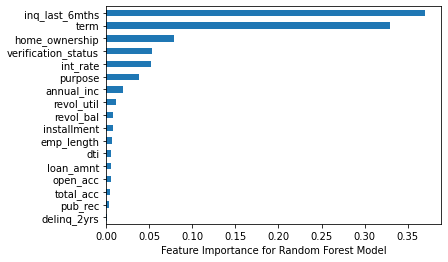

In [ ]:
bestimator = search.best_estimator_
importances = bestimator.named_steps['randomforestclassifier'].feature_importances_
features = X.columns
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.plot(kind='barh')
plt.xlabel('Feature Importance for Random Forest Model');

This plot indicates that the number of inquiries in the last 6 months is the most predictive feature for our model followed by loan term

####Confusion Matrix

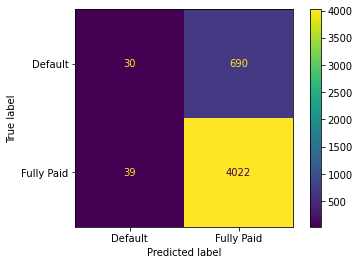

In [ ]:
plot_confusion_matrix(bestimator, X_val,y_val, display_labels = ['Default', 'Fully Paid'],values_format = '.0f')

A confusion matrix is a good evaluation metric for the model because we are interested in seeing the correctly and incorrectly classified samples. We had 4022 true positives(borrowers that would pay off their loan and 30 true negatives(borrowers that would default on their loans). I'm concerned about the high number of false positives(690) as a priority of the predictive model is to prevent defaulting borrowers from being classified as borrowers that would pay off their loan. 

####False Positive Rate

$$$$FPR = $\frac{FP}{FP+TN}$

In [ ]:
print('random forest false positive rate is', 690/(690+30)) #this model has an extremely high false positive rate

random forest false positive rate is 0.9583333333333334


##Building an XG Boost Classifier

In [ ]:
model_xgb = make_pipeline(
    OrdinalEncoder(),  
    SimpleImputer(strategy='mean'), 
    XGBClassifier(random_state=0,n_jobs=-1)
)

# Fit on balanced training data, score on val
model_xgb.fit(X_smtl, y_smtl)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=100, n_jobs=-1, nthread=None,
                               objective='binary:l

In [ ]:
print('Training Accuracy:', model_xgb.score(X_smtl, y_smtl))
print('Validation Accuracy:', model_xgb.score(X_val,y_val))

Training Accuracy: 0.9060776020595808
Validation Accuracy: 0.8483580840828279


####Hyperparameter Tuning

In [ ]:
model_XGB_1 = XGBClassifier()
learning_rates = [0.1,0.3,0.5,0.7,0.9,1]
n_estimators = randint(50,500)
max_depth = [3,5,10,15,20,None]
min_child_weights = [1,2,5,10,20]
subsamples = [0.5,0.7,0.8,1]
grid = dict(learning_rate = learning_rates, n_estimators = n_estimators, min_child_weight = min_child_weights, subsample = subsamples)
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats=3, random_state= 0)
grid_search = RandomizedSearchCV(estimator=model_XGB_1, param_distributions= grid, n_jobs = -1, cv = cv, scoring= 'accuracy', error_score= 0)
grid_result = grid_search.fit(X_smtl,y_smtl)

In [ ]:
grid_search.best_params_

{'learning_rate': 0.1,
 'min_child_weight': 5,
 'n_estimators': 485,
 'subsample': 0.7}

In [ ]:
bestimator_XGB = grid_search.best_estimator_

In [ ]:
#Tuned XG Boost Classifier Model 
model_xgb2 = make_pipeline(
    OrdinalEncoder(),  
    SimpleImputer(strategy='mean'), 
    XGBClassifier(random_state=0,n_jobs=-1, learning_rate= 0.1, min_child_weight= 5, n_estimators= 485, subsample= 0.7)
)

# Fit on balanced training data, score on val
model_xgb2.fit(X_smtl, y_smtl)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=5, missing=None,
                               n_estimators=485, n_jobs=-1, nthread=None,
                               objective='binary:l

In [ ]:
print('Training Accuracy:', model_xgb2.score(X_smtl, y_smtl))
print('Validation Accuracy:', model_xgb2.score(X_val,y_val)) #There is a marginal increase in the training/validation accuracies

Training Accuracy: 0.9196855461566752
Validation Accuracy: 0.8487764066094959


###Testing Data Accuracy for tuned XGB Classifier model

In [ ]:
print('Testing Accuracy:', model_xgb2.score(X_test, y_test)) # the tuned XGB Classifier has about an 86 % accuracy on the testing data 

Testing Accuracy: 0.8595555555555555


###Evaluation Metric

####Feature Selection using Permutation Importance

In [ ]:
# Using sklearn permutation_importance library
from sklearn.inspection import permutation_importance
perm_imp = permutation_importance(model_xgb2,X_test,y_test,random_state=0)

In [ ]:
data = {'imp_mean':perm_imp['importances_mean'],
        'imp_std':perm_imp['importances_std']}
df_perm = pd.DataFrame(data,index=X_test.columns).sort_values(by='imp_mean')

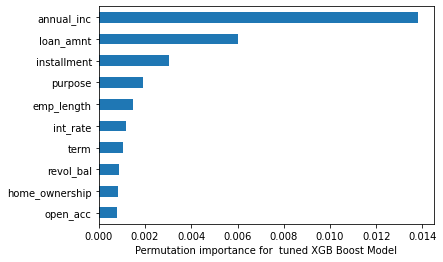

In [ ]:
df_perm['imp_mean'].tail(10).plot(kind='barh')
plt.xlabel('Permutation importance for  tuned XGB Boost Model');

As a reference for potential predictive models, we can see the importance of each feature for predicting if a potential borrower will default on their loan. This illustration measures the increase in the prediction error of our model after permutating various features. A feature's importance is based on if shuffling its values increases the model error due to the reliance of the model on that feature for a prediction. The feature with the highest importance for the XG Boost Classifier was annual_inc. loan_amnt and installment amount are also very important features. Loan amount indicates the amount of the loan applied for by the borrower. Installments represent the monthly payment owed by the borrower if the loan originates.

####Confusion Matrix

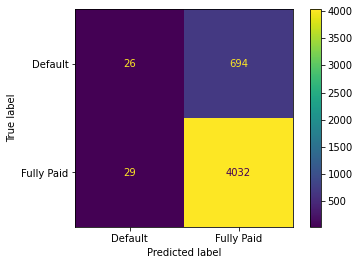

In [ ]:
plot_confusion_matrix(model_xgb2, X_val,y_val, display_labels = ['Default', 'Fully Paid'],values_format = '.0f')

In [ ]:
print('XG Boost Classifier false positive rate is', 694/(694+26)) # appears to have a marginally higher false positive rate than the random forest model but has a higher true positive/lower false negative rate 

XG Boost Classifier false positive rate is 0.9638888888888889


###Logistic Regression

In [ ]:
# Creating a dataframe with one hot encoding for categorical variables to be used by linear model
transformer_log = make_pipeline(
    OneHotEncoder(),
)
trans_X_log = transformer_log.fit_transform(X,y) #transforming categorical variables for linear model

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


#####Train/Test/Validation Split

In [ ]:
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(trans_X_log, y, test_size=0.15, random_state=0)# I will be doing a 70/15/15 split for train/test/validation split

In [ ]:
X_train_log, X_val_log, y_train_log, y_val_log = train_test_split(X_train_log, y_train_log, test_size=0.15, random_state=0) #70/15/15 split#Splitting remainder of training set for a validation holdout set

In [ ]:
print(y_train_log.value_counts()) #distribution of target variable for training set is highly imbalanced 
print(y_test_log.value_counts()) #distribution of target variable for testing set
print(y_val_log.value_counts()) #distribution of target variable for validation set

1    23209
0     3882
Name: loan_status, dtype: int64
1    4843
0     782
Name: loan_status, dtype: int64
1    4061
0     720
Name: loan_status, dtype: int64


In [ ]:
sm_log = SMOTE(
    sampling_strategy = 'auto', # samples only the minority class
    random_state = 0, #for reproducibility
    k_neighbors = 5, 
    n_jobs = 4
)
X_sm_log, y_sm_log = sm.fit_resample(X_train_log,y_train_log)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:

smtomek_log = SMOTETomek(
    sampling_strategy = 'auto', #samples only the minority class
    random_state = 0, 
    smote = sm_log, 
    tomek = t1

)
X_smt_log, y_smt_log = smtomek_log.fit_resample(X_train_log,y_train_log)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
unique_log, counts_log = np.unique(y_smt_log, return_counts= True)

In [ ]:
print(np.array((unique_log,counts_log)).T) #classes are now balanced for our logistic regression model  

[[    0 21751]
 [    1 21751]]


## Establish Baseline

In [ ]:
baseline_acc_log = 21751/43502 #charged off loan as the baseline score
print('Baseline Accuracy Score:', baseline_acc_log)

Baseline Accuracy Score: 0.5


In [ ]:
# I will use the same baseline for the tree based classifiers

##Building a Logistic Regression Model

In [ ]:
model_log = Pipeline(steps = [
                                ('OHE', OneHotEncoder(use_cat_names= True)),
                                ('impute', SimpleImputer(strategy='mean')), 
                                ('scale', StandardScaler()),
                                ('logit', LogisticRegression())])
                               

In [ ]:
model_log.fit(X_smt_log, y_smt_log)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(memory=None,
         steps=[('OHE',
                 OneHotEncoder(cols=[], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               return_df=True, use_cat_names=True, verbose=0)),
                ('impute',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logit',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                

In [ ]:
print('Training Accuracy:',model_log.score(X_smt_log, y_smt_log))
print('Validation Accuracy:', model_log.score(X_val_log,y_val_log))

Training Accuracy: 0.6632568617534826
Validation Accuracy: 0.6722443003555741


In [ ]:
# The logistic regression model appears to perform worse than both of the tree based classifiers

####Hyperparameter Tuning

In [ ]:
model_log1 = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l1','l2','elasticnet','none']
c_values = [100,10,1.0,0.1,0.01]
grid_log = dict(solver = solvers, penalty = penalty, C = c_values)
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats=3, random_state= 1)
grid_search_log = RandomizedSearchCV(estimator=model_log1, param_distributions= grid_log, n_jobs = -1, cv = cv, scoring= 'accuracy', error_score= 0)
grid_result_log = grid_search_log.fit(X_smt_log,y_smt_log)

In [ ]:
print('Training Accuracy:', grid_search_log.score(X_smt_log, y_smt_log))
print('Validation Accuracy:', grid_search_log.score(X_val_log,y_val_log))


Training Accuracy: 0.6632338743046297
Validation Accuracy: 0.6728717841455762


In [ ]:
grid_search_log.best_params_ #best hyperparameters for the logistic regression model 

{'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}

In [ ]:
print('The best accuracy score for the grid search is: ', grid_search_log.best_score_)

The best accuracy score for the grid search is:  0.6626285655915626


###Evaluation Metric

In [ ]:
bestimator_log = grid_search_log.best_estimator_

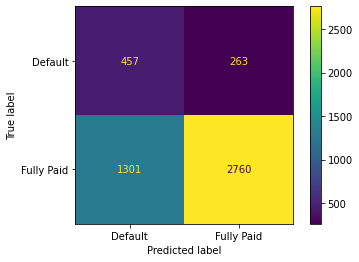

In [ ]:
plot_confusion_matrix(bestimator_log, X_val_log,y_val_log,  display_labels = ['Default', 'Fully Paid'],values_format = '.0f')

In [ ]:
print('Logistic regression false positive rate is', 263/(263+457))

Logistic regression false positive rate is 0.36527777777777776


##Conclusion

All of our models performed better than the baseline. However, the XGBOOST classifier model performed the best with about an 86 % testing accuracy. In second place, the tuned random forest model had about an 85 % accuracy on the validation data. The logistic regression model performed the worst in terms of accuracy at about a 66% validation accuracy. For my evaluation metric I chose a confusion matrix in addition to accuracy score.  since Minimizing financial risk for the investor is a key goal of our model, a confusion matrix would give a clear depiction of the false positives and false positive rate for each model. Naturally, the best model would minimize the number of the nagative class incorrectly classified as a paid off loan.We can potentially further improve the reduction of the false positive rate by using a larger probability threshold to minimize the false positive rate. However, using a larger probability threshold would also decrease the true positive rate. Despite the logistic regression having the lowest accuracy score, it had the lowest false positive rate at about 37 %. Furthermore, the logistic regression model had better specificity than the other models by having better performance in predicting true negatives. This is beneficial as we want to avoid having potential defaulting borrowers from being classified as borrowers that will pay their loans. Ultimately, we care care more about a lower false positive rate in order to prevent financial losses for the lender. 

In [ ]:
print('random forest false positive rate is', 690/(690+30)) 
print('XG Boost Classifier false positive rate is', 694/(694+26)) 
print('Logistic regression false positive rate is', 263/(263+457))


random forest false positive rate is 0.9583333333333334
XG Boost Classifier false positive rate is 0.9638888888888889
Logistic regression false positive rate is 0.36527777777777776


####Feature Selection for Future Reference

In [ ]:
# Using sklearn permutation_importance library
from sklearn.inspection import permutation_importance
perm_imp_log = permutation_importance(bestimator_log,X_val_log,y_val_log,random_state=0)

In [ ]:
data = {'imp_mean':perm_imp_log['importances_mean'],
        'imp_std':perm_imp_log['importances_std']}
df_perm_log = pd.DataFrame(data,index=X_val_log.columns).sort_values(by='imp_mean')

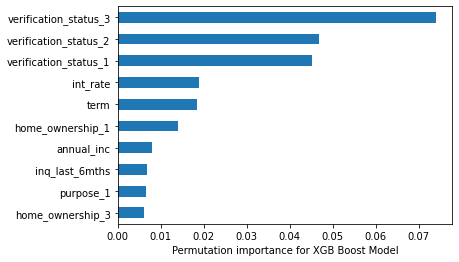

In [ ]:
df_perm_log['imp_mean'].tail(10).plot(kind='barh')
plt.xlabel('Permutation importance for XGB Boost Model');

As a reference for potential predictive models, we can see the importance of each feature for predicting if a potential borrower will default on their loan for the logistic regression model. This illustration measures the increase in the prediction error of our model after permutating various features. A feature's importance is based on if shuffling its values increases the model error due to the reliance of the model on that feature for a prediction. The feature with the highest importance was if verification status of salary was 'not verified'. .Intuitively, borrowers that don't have a verified income are at higher risk of defaulting on their loans. loan interest rate and term are also very important features. A higher interest rate can be indicative of a low credit score. Term represents the number of payments on the loan. 

####Model Interpretation

#####Partial Dependence for XGB Classifier

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f47fff6d3d0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4800080f50>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


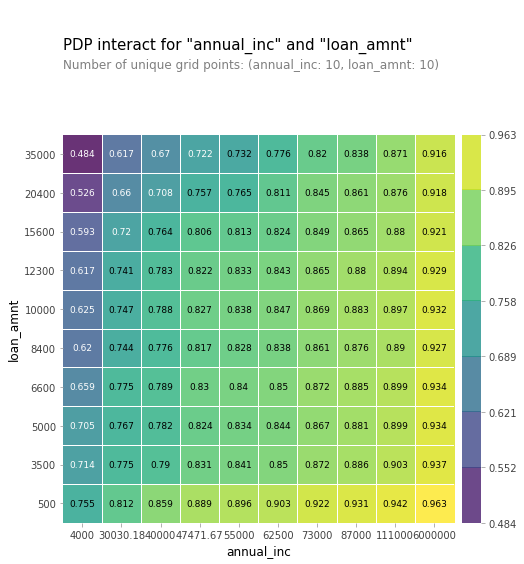

In [ ]:
features = ['annual_inc','loan_amnt']
interact = pdp_interact(model_xgb2,
                        dataset = trans_X,
                        model_features = X.columns,
                        features=features)

pdp_interact_plot(interact,plot_type='grid',feature_names = features)

This partial dependence plot shows the loan status probabilities given the interaction of a borrower's annual income and loan amount the borrower desires. The plot shows the increase in the probability that a borrower will fully pay a loan given an increased annual income. Borrower's with a lower loan amount   had an overall higher probability of paying back their loan. Borrower's that choose a loan amount of 35,000 dollars and with an annual income of 4,000 dollars had  had the lowest probability of paying back a loan.

#####Shapley Plots for XGB Classifier

In [ ]:
import shap

In [ ]:
samp = df.head(2)
samp

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc
0,5000,36,10.65,162.87,10,RENT,24000.0,Verified,1,credit_card,27.65,0,1,3,0,13648,83.7,9
1,2500,60,15.27,59.83,0,RENT,30000.0,Source Verified,0,car,1.00,0,5,3,0,1687,9.4,4


In [ ]:
model_xgb2 = XGBClassifier(random_state=0, n_jobs= -1)
model_xgb2.fit(trans_X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
explainer = shap.TreeExplainer(model_xgb2) # SHAP DOESNT NOT TAKE IN PIPELINES
shap_values = explainer.shap_values(trans_X.loc[0])

shap.initjs()
shap.force_plot(base_value=explainer.expected_value,
                shap_values = shap_values,
                features=trans_X.loc[0])



In [ ]:
explainer = shap.TreeExplainer(model_xgb2) # SHAP DOESNT NOT TAKE IN PIPELINES
shap_values = explainer.shap_values(trans_X.loc[1])

shap.initjs()
shap.force_plot(base_value=explainer.expected_value,
                shap_values = shap_values,
                features=trans_X.loc[1])


These shap force plots show how the individual features effect the predictions of individual samples. The first case has a higher predicted probabibility of paying back their loan. Defaulting risk increasing effects like a low annual income are offset by factors such as a short repayment term

The second borrower has a significantly lower probability of paying back their loan in full. The 5 inquiries over the past 6 months and a longer repayment period increases the borrowers risk of defaulting on their loan.

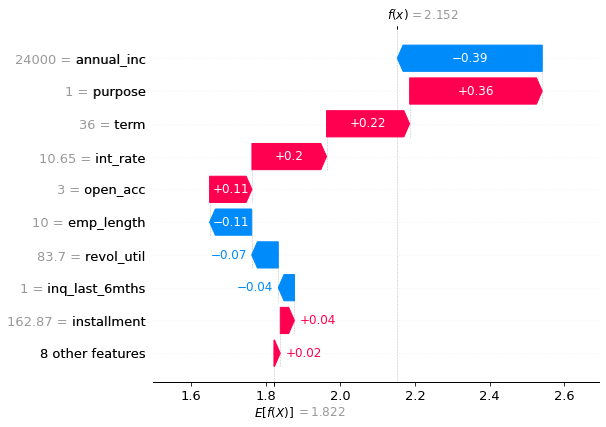

In [ ]:
explainer=shap.TreeExplainer(model_xgb2)
shap_values=explainer(trans_X)
shap.plots.waterfall(shap_values[0])

In [ ]:
#For this particular borrower we can see that the low annual income effects were largely offset by purpose of the loan. A shorter repayment term also helped offset other negative factors